In [50]:
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.optim import Adam

import os
from PIL import Image
import matplotlib.pyplot as plt

from torchsummary import summary
from tqdm import tqdm

In [51]:
# from google.colab import drive
# drive.mount('/content/drive')

In [52]:
# import kagglehub

# path = kagglehub.dataset_download("ipythonx/wikiart-gangogh-creating-art-gan")

# print("Path to dataset files:", path)

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [54]:
device

'cuda'

In [55]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [56]:
class CustomDataset(Dataset):
    def __init__(self, link, transformer=None):

        self.data = link
        self.data_list = sorted(os.listdir(self.data))
        self.transformer = transformer

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_link = os.path.join(self.data, self.data_list[idx])
        img = Image.open(img_link).convert("RGB")

        if self.transformer is not None:
            img = self.transformer(img)


        return img

In [57]:
link = "/kaggle/input/images/landscape"
dataset = CustomDataset(link, transformer)

In [58]:
len(dataset)

15000

In [59]:
def output(limit, dataset, axis=False):
    for i, (x) in enumerate(dataset):

        x = x.permute(1, 2, 0).cpu().numpy()
        x = (x + 1) / 2
        plt.imshow(x)

        if axis == True:
            plt.axis("on")
        else:
            plt.axis("off")
        plt.show()

        if i+1 >= limit:
            break

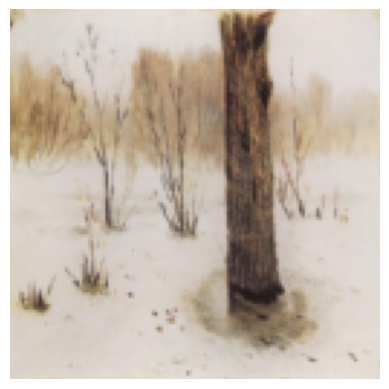

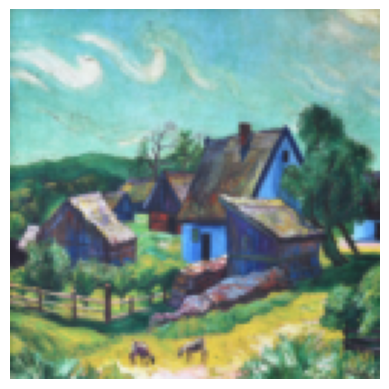

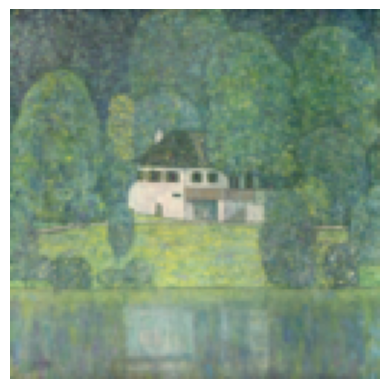

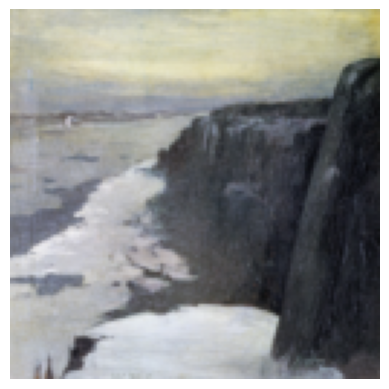

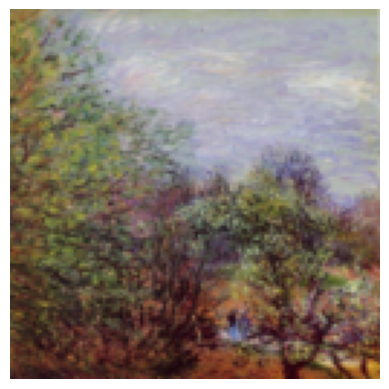

In [60]:
output(5, dataset)

In [61]:
batch_size = 128

dl = DataLoader(dataset, batch_size = batch_size, shuffle=True, num_workers=4)

In [62]:
# x = next(iter(dl))
# print(x.shape)

In [63]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        
    def forward(self, x):
        out = self.conv(x)
        out = F.leaky_relu(out, 0.2)
        return out 
        

In [64]:
tensor = torch.randn(1, 3, 128, 128)
block = ConvBlock(3, 32, 4, 2, 1)

out = block(tensor)
out.shape

torch.Size([1, 32, 64, 64])

In [65]:
import torch.nn.utils.spectral_norm as SN


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # 3, 128, 128
        self.conv1 = ConvBlock(3, 32, 4, 2, 1)
        
        # 32, 64, 64
        self.conv2 = ConvBlock(32, 64, 4, 2, 1)
       
        # 64, 32, 32
        self.conv3 = ConvBlock(64, 128, 4, 2, 1)
        
        # 128, 16, 16
        self.conv4 = ConvBlock(128, 256, 4, 2, 1)
        
        # 128, 8, 8
        self.conv5 = ConvBlock(256, 512, 4, 2, 1)
    

        self.flatten = nn.Flatten()

        self.linear1 = SN(nn.Linear(512 * 4 * 4, 1))
        # self.linear2 = SN(nn.Linear(512, 1))

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        # out = F.leaky_relu(self.conv5(out), 0.2)
        
        out = self.flatten(out)
        out = self.linear1(out)
        return out 
        # out = self.linear2(out)

        return out

    def predict(self, x):
        self.eval()

        if len(x.shape) == 3:
            x = x.unsqueeze(0)

        with torch.no_grad():
            out = self.forward(x)

        # res = torch.sigmoid(out)
        # res = int(res.item() >= 0.5)

        return out



In [66]:
512 * 8 * 8

32768

In [67]:
discriminator = Discriminator()
tensor = torch.randn(1, 3, 128, 128)

out = discriminator(tensor)
out.shape

torch.Size([1, 1])

In [68]:
discriminator = Discriminator()
tensor = torch.randn(1, 3, 128, 128)

out = discriminator.predict(tensor)
out

tensor([[-1.6696]])

In [69]:
discriminator.to(device)

Discriminator(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): ConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv4): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv5): ConvBlock(
    (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=8192, out_features=1, bias=True)
)

In [70]:
summary(discriminator, input_size=(3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,568
         ConvBlock-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 32, 32]          32,832
         ConvBlock-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]         131,200
         ConvBlock-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,544
         ConvBlock-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
        ConvBlock-10            [-1, 512, 4, 4]               0
          Flatten-11                 [-1, 8192]               0
           Linear-12                    [-1, 1]           8,193
Total params: 2,796,001
Trainable params: 2,796,001
Non-trainable params: 0
---------------------------

In [71]:
class PixelNorm(nn.Module):
    def forward(self, x, eps=1e-8):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + eps)

class NoiseInjection(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x, noise=None):
        if noise is None:
            noise = torch.randn_like(x)
        return x + self.weight * noise

In [72]:
class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, upsampling=False):
        super().__init__()

        if upsampling == True:
            self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        else:
            self.upsample = nn.Identity()
            
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.noise = NoiseInjection(out_channels)
        self.norm = PixelNorm()

    def forward(self, x):
        out = self.upsample(x)
        out = self.conv(out)
        out = self.noise(out)
        out = F.leaky_relu(out, 0.2)
        out = self.norm(out)
        return out

In [73]:
class SEBlock(nn.Module):
    def __init__(self, C, r=16):
        super().__init__()

        self.aap = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(C, C//r)
        self.linear2 = nn.Linear(C//r, C)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.aap(x)
        out = self.flatten(out)

        out = self.relu(self.linear1(out))
        out = self.sigmoid(self.linear2(out))

        out = out[:, :, None, None]

        res = out * x

        return res

In [74]:
tensor = torch.randn(1, 32, 128, 128)
block = SEBlock(32)

out = block(tensor)
out.shape

torch.Size([1, 32, 128, 128])

In [75]:
class SABlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.q = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.k = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.v = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        self.norm = nn.InstanceNorm2d(in_channels)
        
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        B, C, H, W = x.shape
        
        Q = self.q(x).view(B, -1, H*W).permute(0, 2, 1)  # B, C, N -> B, N, C
        K = self.k(x).view(B, -1, H*W)   # B, C, N
        V = self.v(x).view(B, -1, H*W).permute(0, 2, 1)  # B, C, N -> B, N, C
        
        d_k = Q.size(-1)
        
        attention = torch.bmm(Q, K) / d_k ** 0.5
        attention = F.softmax(attention, dim=-1)
        
        out = torch.bmm(attention, V)
        out = out.permute(0, 2, 1).view(B, C, H, W)

        out = self.norm(out)
        
        return self.gamma * out + x 
        
        

In [76]:
tensor = torch.randn(1, 64, 64, 64)
block = SABlock(64)

out = block(tensor)
out.shape

torch.Size([1, 64, 64, 64])

In [77]:
tensor = torch.randn(1, 512, 4, 4)
block = GenBlock(512, 256, 3, 1, 1, True)

out = block(tensor)
out.shape

torch.Size([1, 256, 8, 8])

In [78]:
class Generator(nn.Module):
    def __init__(self, z = 512):
        super().__init__()

        self.linear1 = nn.Linear(512, 512 * 4 * 4)
         
        self.conv1 = GenBlock(512, 512, 3, 1, 1, upsampling=True)
        self.se1 = SEBlock(512)

        self.conv2 = GenBlock(512, 256, 3, 1, 1, upsampling=True)
        self.sa2 = SABlock(256)
       
        self.conv3 = GenBlock(256, 128, 3, 1, 1, upsampling=True)
        self.se3 = SEBlock(128)

        self.conv4 = GenBlock(128, 128, 3, 1, 1, upsampling=False)

        self.conv5 = GenBlock(128, 64, 3, 1, 1, upsampling=True)
        
        self.conv6 = GenBlock(64, 32, 3, 1, 1, upsampling=True)

        self.conv_out = nn.Conv2d(32, 3, 1)

    def forward(self, x):
        
        out = F.leaky_relu(self.linear1(x), 0.2)
        
        out = out.view(-1, 512, 4, 4)

        out = self.conv1(out)
        out = self.se1(out)

        out = self.conv2(out)
        out = self.sa2(out)
        
        out = self.conv3(out)
        out = self.se3(out)

        out = self.conv4(out)
    
        out = self.conv5(out)

        out = self.conv6(out)
      
        res = torch.tanh(self.conv_out(out))

        return res

    def predict(self, x):
        self.eval()

        with torch.no_grad():
            out = self.forward(x).cpu()
            out = (out + 1) / 2
            out = out.squeeze(0).permute(1, 2, 0).numpy()
            
        return out

In [79]:
generator = Generator()
tensor = torch.randn(1, 512)
out = generator(tensor)
out.shape

torch.Size([1, 3, 128, 128])

In [80]:
tensor = torch.randn(1, 512)
pred = generator.predict(tensor)
pred.shape

(128, 128, 3)

In [81]:
generator.to(device)

Generator(
  (linear1): Linear(in_features=512, out_features=8192, bias=True)
  (conv1): GenBlock(
    (upsample): Upsample(scale_factor=2.0, mode='nearest')
    (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (noise): NoiseInjection()
    (norm): PixelNorm()
  )
  (se1): SEBlock(
    (aap): AdaptiveAvgPool2d(output_size=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=512, out_features=32, bias=True)
    (linear2): Linear(in_features=32, out_features=512, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (conv2): GenBlock(
    (upsample): Upsample(scale_factor=2.0, mode='nearest')
    (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (noise): NoiseInjection()
    (norm): PixelNorm()
  )
  (sa2): SABlock(
    (q): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (k): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (v): Conv2d(256, 256, kernel_size=(1, 1), strid

In [82]:
summary(generator, input_size=(512,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]       4,202,496
          Upsample-2            [-1, 512, 8, 8]               0
            Conv2d-3            [-1, 512, 8, 8]       2,359,808
    NoiseInjection-4            [-1, 512, 8, 8]             512
         PixelNorm-5            [-1, 512, 8, 8]               0
          GenBlock-6            [-1, 512, 8, 8]               0
 AdaptiveAvgPool2d-7            [-1, 512, 1, 1]               0
           Flatten-8                  [-1, 512]               0
            Linear-9                   [-1, 32]          16,416
             ReLU-10                   [-1, 32]               0
           Linear-11                  [-1, 512]          16,896
          Sigmoid-12                  [-1, 512]               0
          SEBlock-13            [-1, 512, 8, 8]               0
         Upsample-14          [-1, 512,

In [83]:
def generate(model, limit):
    z = torch.randn(limit, 512).to(device)
    
    model.eval()
    
    with torch.no_grad():
        preds = model(z)
    
        plt.figure(figsize=(10, 10))
        for i in range(limit):
            img = preds[i].permute(1, 2, 0).cpu().numpy()
            img = (img + 1) / 2
            plt.subplot(5, 5, i+1)
            plt.axis("off")
            plt.imshow(img)
    
        plt.show()

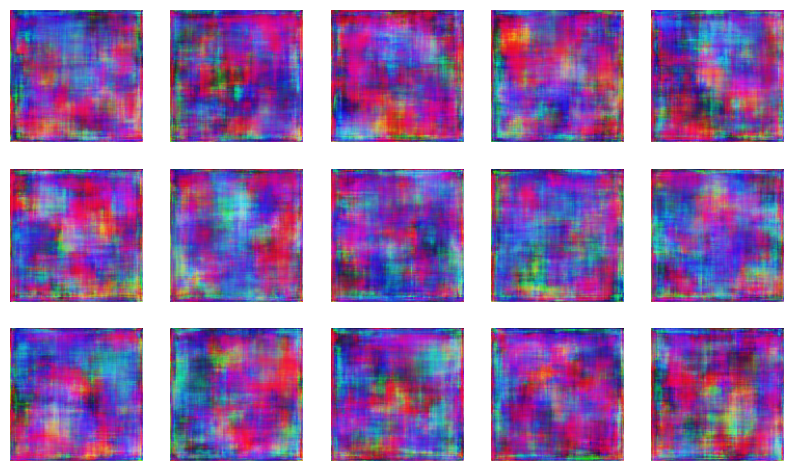

In [84]:
generate(generator, 15)

In [85]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.0, 0.9))

D_optim = Adam(discriminator.parameters(), lr=1e-4, betas=(0.0, 0.9))
G_optim = Adam(generator.parameters(), lr=1e-3, betas=(0.0, 0.9))

In [86]:
# D_loss_fn = nn.BCEWithLogitsLoss()

D_loss_fn = nn.MSELoss()
G_loss_fn = nn.MSELoss()


In [87]:
def get_gp(discriminator, reals, fakes, device):
  bs = reals.size(0)

  eps = torch.rand(bs, 1, 1, 1).to(device)

  interpolated = eps * reals + (1 -  eps) * fakes

  interpolated.requires_grad_(True)

  mixed_scores = discriminator(interpolated)

  gradients = torch.autograd.grad(
      outputs = mixed_scores,
      inputs = interpolated,
      grad_outputs = torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
      only_inputs = True
  )[0]

  gradients = gradients.view(bs, -1)
  grad_norm = gradients.norm(2, dim=1)

  penalty = ((grad_norm - 1) ** 2).mean()

  return penalty



In [88]:
def train(dl, D_optim, G_optim, generator, discriminator, epochs, device, D_step, to_display, l=13):
    history = {
        "D_loss": [],
        "G_loss": []
    }


    for epoch in range(epochs):
        D_losses = 0.0
        G_losses = 0.0
        generator.train()
        discriminator.train()

        for x in tqdm(dl):
            x = x.to(device)
            bs = x.shape[0]

            for _ in range(D_step):

              D_optim.zero_grad()
              z = torch.randn(bs, 512).to(device)
              z = z / (z.norm(2, dim=1, keepdim=True) + 1e-8)  
              gen_img = generator(z)

              reals = discriminator(x)
              fakes = discriminator(gen_img.detach())

              gp = get_gp(discriminator, x, gen_img.detach(), device)

              D_loss = torch.mean(fakes) - torch.mean(reals) + l * gp
              D_loss.backward()
              D_optim.step()

              D_losses += D_loss.item()


            G_optim.zero_grad()

            z = torch.randn(bs, 512).to(device)
            z = z / (z.norm(2, dim=1, keepdim=True) + 1e-8)
            gen_img = generator(z)

            G_loss = - discriminator(gen_img).mean()
            G_loss.backward()
            G_optim.step()

            G_losses += G_loss.item()


        for i in range(to_display):
            z = torch.randn(1, 512).to(device)
            z = z / (z.norm(2, dim=1, keepdim=True) + 1e-8)
            gen_img = generator.predict(z)
            gen_img_tensor = torch.tensor(gen_img, dtype=torch.float).to(device)
            gen_img_tensor = gen_img_tensor.permute(2, 0, 1).unsqueeze(0)
            res = discriminator.predict(gen_img_tensor)

            plt.subplot(1, to_display, i+1)
            # plt.figure(figsize=(18, 11))
            plt.imshow(gen_img)
            plt.title(f"{res.item():.4f}")
            plt.axis("off")

        plt.show()



        fin_G_loss = G_losses / len(dl)
        fin_D_loss = D_losses / len(dl)

        history["G_loss"].append(fin_G_loss)
        history["D_loss"].append(fin_D_loss)

        print(f"Epoch: {epoch+1}, Generator_loss: {fin_G_loss:.4f}, Discriminator_loss: {fin_D_loss:.4f}")

    return history





100%|██████████| 118/118 [04:08<00:00,  2.11s/it]


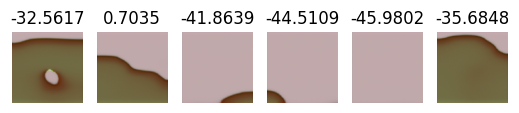

Epoch: 1, Generator_loss: 29.2830, Discriminator_loss: -35.8004


100%|██████████| 118/118 [04:11<00:00,  2.13s/it]


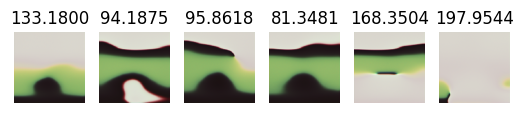

Epoch: 2, Generator_loss: 16.4398, Discriminator_loss: -9.1420


100%|██████████| 118/118 [04:13<00:00,  2.15s/it]


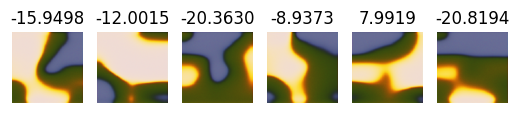

Epoch: 3, Generator_loss: 27.4812, Discriminator_loss: -7.6731


100%|██████████| 118/118 [04:09<00:00,  2.11s/it]


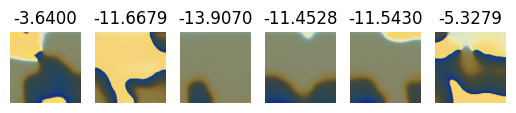

Epoch: 4, Generator_loss: 17.8341, Discriminator_loss: -16.8653


100%|██████████| 118/118 [04:08<00:00,  2.11s/it]


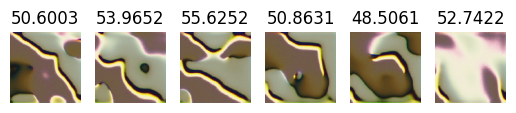

Epoch: 5, Generator_loss: 0.4384, Discriminator_loss: -15.9759


100%|██████████| 118/118 [04:10<00:00,  2.12s/it]


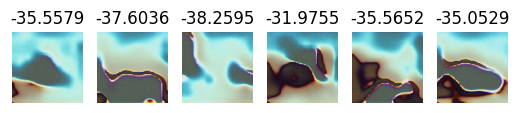

Epoch: 6, Generator_loss: 10.7194, Discriminator_loss: -7.1600


100%|██████████| 118/118 [04:13<00:00,  2.15s/it]


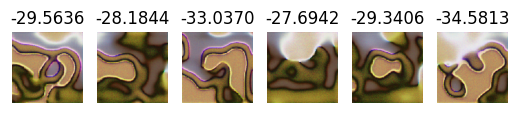

Epoch: 7, Generator_loss: 11.2396, Discriminator_loss: -4.6603


100%|██████████| 118/118 [04:06<00:00,  2.09s/it]


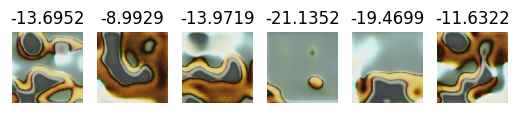

Epoch: 8, Generator_loss: 11.8956, Discriminator_loss: -2.9120


100%|██████████| 118/118 [04:08<00:00,  2.10s/it]


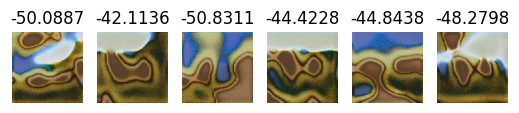

Epoch: 9, Generator_loss: 18.2489, Discriminator_loss: -1.6298


100%|██████████| 118/118 [04:07<00:00,  2.10s/it]


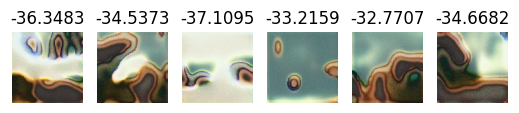

Epoch: 10, Generator_loss: 13.1228, Discriminator_loss: -1.0567


100%|██████████| 118/118 [04:09<00:00,  2.11s/it]


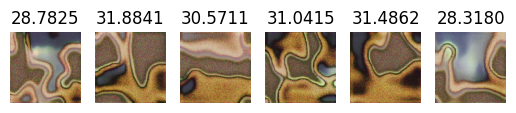

Epoch: 11, Generator_loss: 11.9970, Discriminator_loss: -1.5646


100%|██████████| 118/118 [04:09<00:00,  2.11s/it]


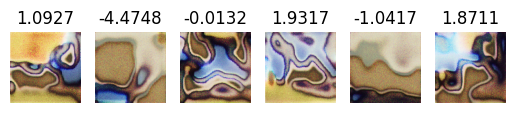

Epoch: 12, Generator_loss: 9.2157, Discriminator_loss: -0.6691


100%|██████████| 118/118 [04:13<00:00,  2.15s/it]


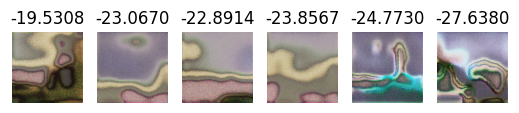

Epoch: 13, Generator_loss: 10.8020, Discriminator_loss: -1.2791


100%|██████████| 118/118 [04:13<00:00,  2.15s/it]


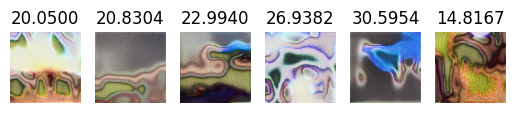

Epoch: 14, Generator_loss: 5.6684, Discriminator_loss: -1.3402


100%|██████████| 118/118 [04:05<00:00,  2.08s/it]


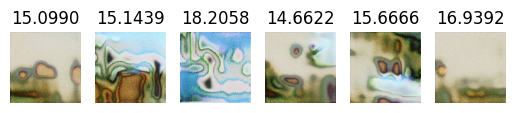

Epoch: 15, Generator_loss: 4.9631, Discriminator_loss: -1.3801


100%|██████████| 118/118 [04:10<00:00,  2.12s/it]


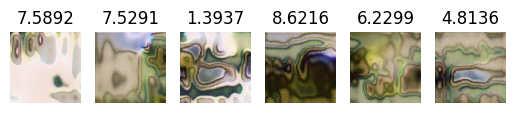

Epoch: 16, Generator_loss: 3.2100, Discriminator_loss: -1.2272


100%|██████████| 118/118 [04:11<00:00,  2.13s/it]


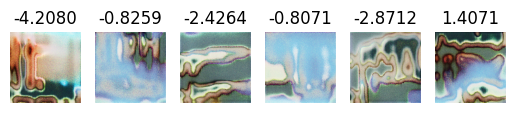

Epoch: 17, Generator_loss: 0.9641, Discriminator_loss: -1.1385


100%|██████████| 118/118 [04:11<00:00,  2.13s/it]


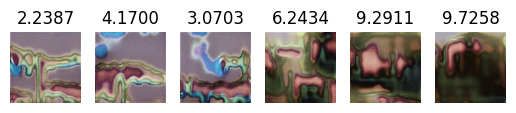

Epoch: 18, Generator_loss: 1.6728, Discriminator_loss: -1.4785


100%|██████████| 118/118 [04:13<00:00,  2.15s/it]


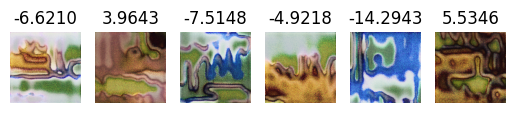

Epoch: 19, Generator_loss: -0.1095, Discriminator_loss: -1.1556


100%|██████████| 118/118 [04:04<00:00,  2.08s/it]


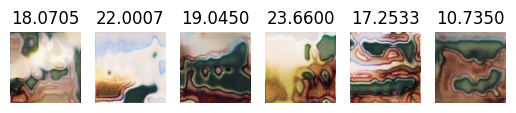

Epoch: 20, Generator_loss: -2.9371, Discriminator_loss: -1.4198


100%|██████████| 118/118 [04:06<00:00,  2.09s/it]


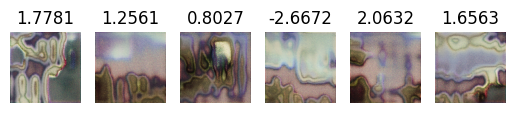

Epoch: 21, Generator_loss: -0.7640, Discriminator_loss: -1.1194


100%|██████████| 118/118 [04:13<00:00,  2.15s/it]


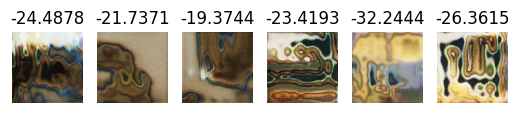

Epoch: 22, Generator_loss: -4.1607, Discriminator_loss: -2.0982


100%|██████████| 118/118 [04:11<00:00,  2.13s/it]


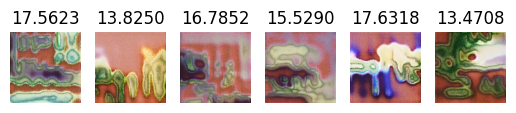

Epoch: 23, Generator_loss: -0.2889, Discriminator_loss: -1.3091


100%|██████████| 118/118 [04:04<00:00,  2.07s/it]


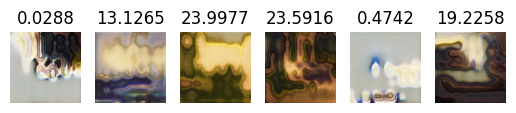

Epoch: 24, Generator_loss: -0.4625, Discriminator_loss: -1.5436


100%|██████████| 118/118 [04:12<00:00,  2.14s/it]


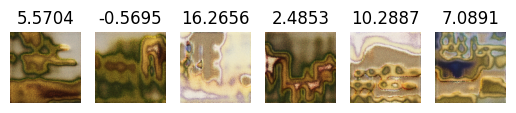

Epoch: 25, Generator_loss: -5.1319, Discriminator_loss: -1.6440


100%|██████████| 118/118 [04:15<00:00,  2.16s/it]


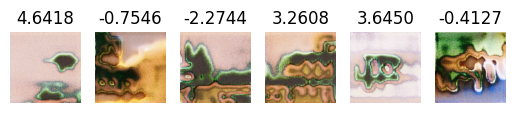

Epoch: 26, Generator_loss: -3.2786, Discriminator_loss: -1.7460


100%|██████████| 118/118 [04:04<00:00,  2.07s/it]


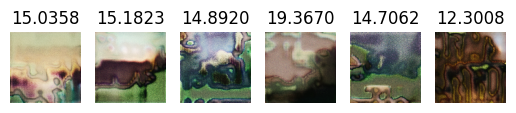

Epoch: 27, Generator_loss: -0.8904, Discriminator_loss: -1.6515


100%|██████████| 118/118 [04:10<00:00,  2.12s/it]


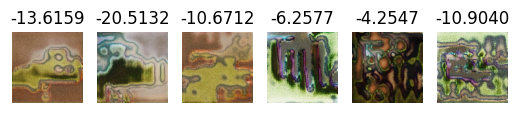

Epoch: 28, Generator_loss: 0.6518, Discriminator_loss: -2.1445


100%|██████████| 118/118 [04:09<00:00,  2.12s/it]


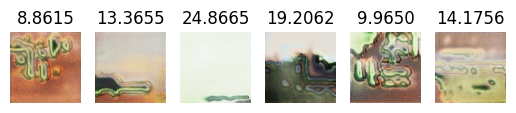

Epoch: 29, Generator_loss: 1.0373, Discriminator_loss: -2.0071


100%|██████████| 118/118 [04:04<00:00,  2.07s/it]


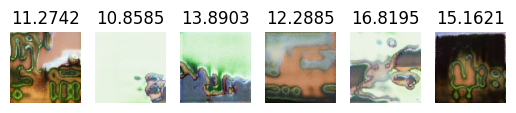

Epoch: 30, Generator_loss: 2.3225, Discriminator_loss: -2.6337


100%|██████████| 118/118 [04:11<00:00,  2.13s/it]


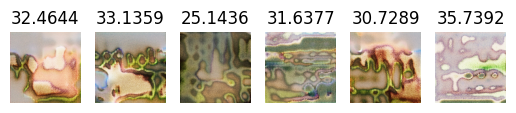

Epoch: 31, Generator_loss: -1.9071, Discriminator_loss: -2.3353


100%|██████████| 118/118 [04:07<00:00,  2.10s/it]


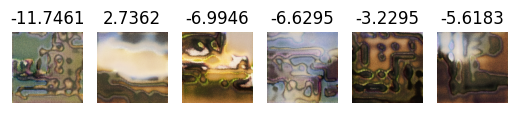

Epoch: 32, Generator_loss: -0.5800, Discriminator_loss: -2.3296


100%|██████████| 118/118 [04:10<00:00,  2.12s/it]


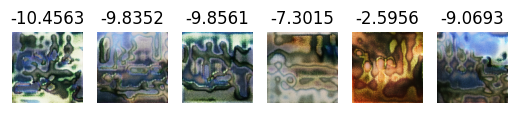

Epoch: 33, Generator_loss: 0.8342, Discriminator_loss: -2.5887


100%|██████████| 118/118 [04:10<00:00,  2.12s/it]


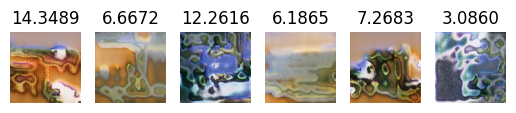

Epoch: 34, Generator_loss: -5.6589, Discriminator_loss: -2.9839


100%|██████████| 118/118 [04:10<00:00,  2.12s/it]


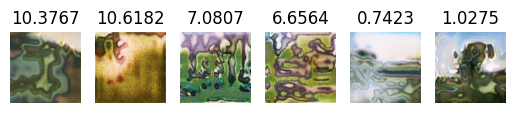

Epoch: 35, Generator_loss: -2.4609, Discriminator_loss: -3.1176


100%|██████████| 118/118 [04:12<00:00,  2.14s/it]


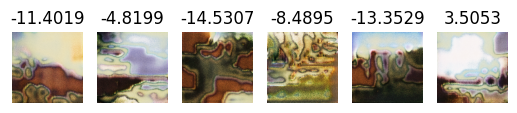

Epoch: 36, Generator_loss: 0.6198, Discriminator_loss: -3.1393


100%|██████████| 118/118 [04:06<00:00,  2.09s/it]


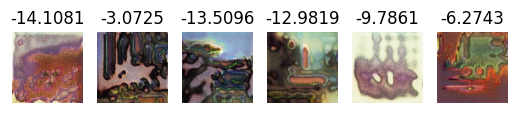

Epoch: 37, Generator_loss: 0.2553, Discriminator_loss: -3.3023


100%|██████████| 118/118 [04:09<00:00,  2.11s/it]


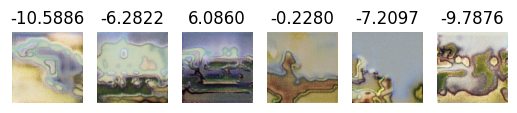

Epoch: 38, Generator_loss: 3.0180, Discriminator_loss: -3.3743


100%|██████████| 118/118 [04:09<00:00,  2.12s/it]


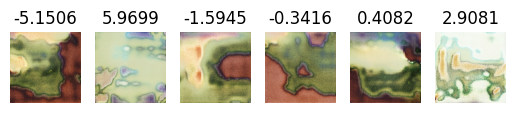

Epoch: 39, Generator_loss: 0.6569, Discriminator_loss: -4.5559


100%|██████████| 118/118 [04:09<00:00,  2.12s/it]


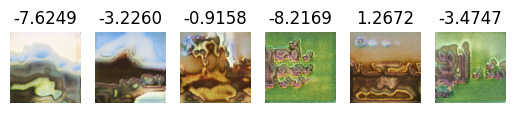

Epoch: 40, Generator_loss: -3.5791, Discriminator_loss: -4.3285


100%|██████████| 118/118 [04:16<00:00,  2.18s/it]


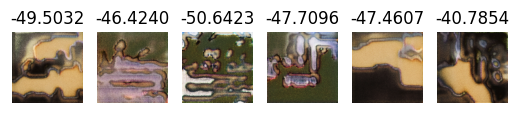

Epoch: 41, Generator_loss: 0.0233, Discriminator_loss: -4.3982


100%|██████████| 118/118 [04:08<00:00,  2.11s/it]


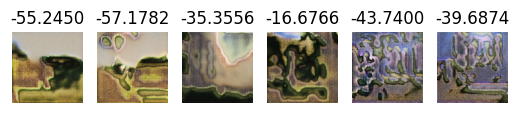

Epoch: 42, Generator_loss: -0.4916, Discriminator_loss: -3.8502


100%|██████████| 118/118 [04:10<00:00,  2.13s/it]


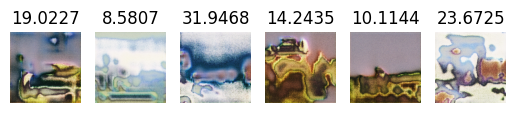

Epoch: 43, Generator_loss: -4.5816, Discriminator_loss: -3.8080


100%|██████████| 118/118 [04:13<00:00,  2.15s/it]


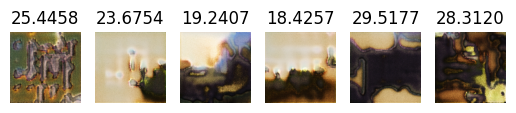

Epoch: 44, Generator_loss: 0.2647, Discriminator_loss: -4.2896


100%|██████████| 118/118 [04:11<00:00,  2.13s/it]


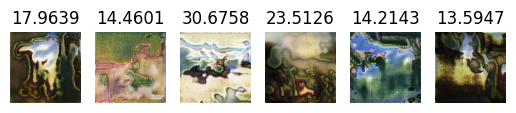

Epoch: 45, Generator_loss: -4.7624, Discriminator_loss: -4.2033


100%|██████████| 118/118 [04:14<00:00,  2.15s/it]


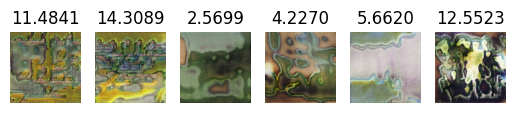

Epoch: 46, Generator_loss: -1.3447, Discriminator_loss: -4.3280


100%|██████████| 118/118 [04:10<00:00,  2.12s/it]


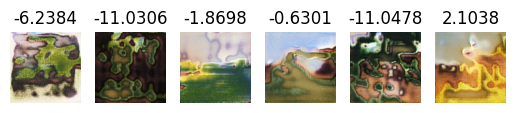

Epoch: 47, Generator_loss: 3.0415, Discriminator_loss: -4.3630


100%|██████████| 118/118 [04:11<00:00,  2.13s/it]


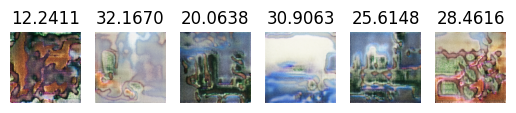

Epoch: 48, Generator_loss: 2.8645, Discriminator_loss: -4.4624


100%|██████████| 118/118 [04:10<00:00,  2.12s/it]


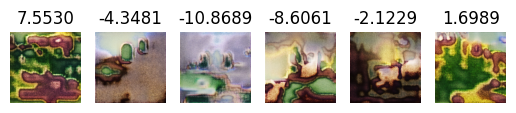

Epoch: 49, Generator_loss: 3.6229, Discriminator_loss: -4.4772


100%|██████████| 118/118 [04:13<00:00,  2.15s/it]


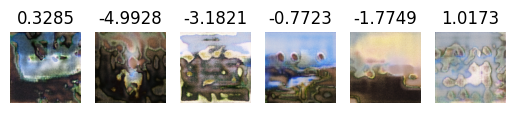

Epoch: 50, Generator_loss: -1.1145, Discriminator_loss: -4.9198


In [89]:
history =  train(dl, D_optim, G_optim, generator, discriminator, 50, device, 2, 6)

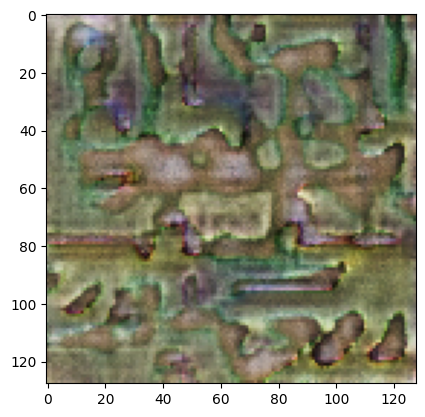

In [90]:
tensor = torch.randn(1, 512).to(device)
res = generator.predict(tensor)
plt.imshow(res)

In [91]:
# link = ""
# generate.load_state_dict(torch.load(link, map_location=device))

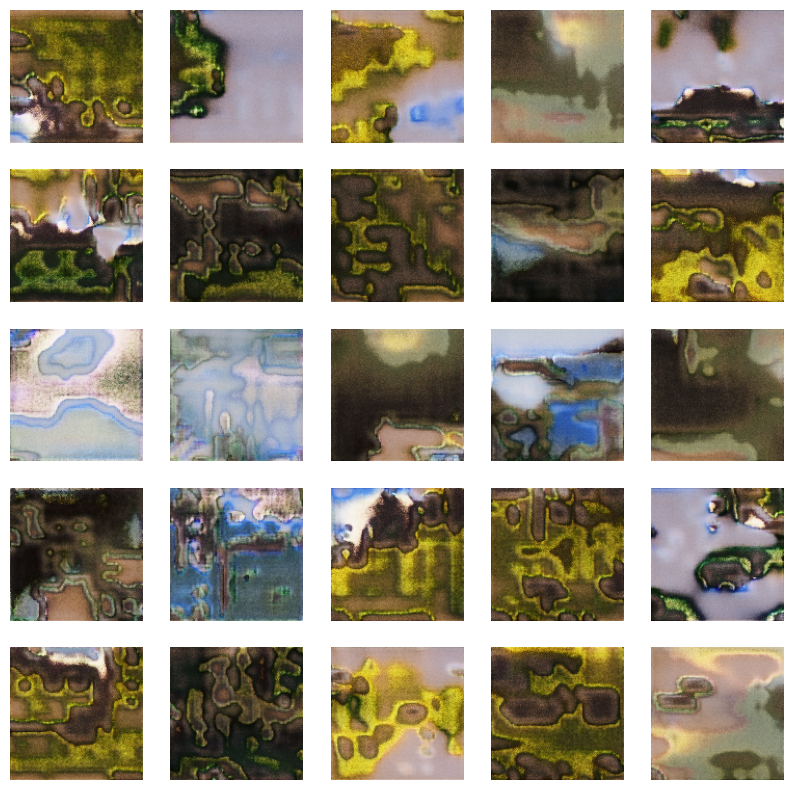

In [92]:
generate(generator, 25)

In [93]:
torch.save(generator.state_dict(), "landscape_generator_V02.pt")